# Guiding DIP Early Stopping with DDPM (CNN model with 32 layers)

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr


%matplotlib inline

In [2]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


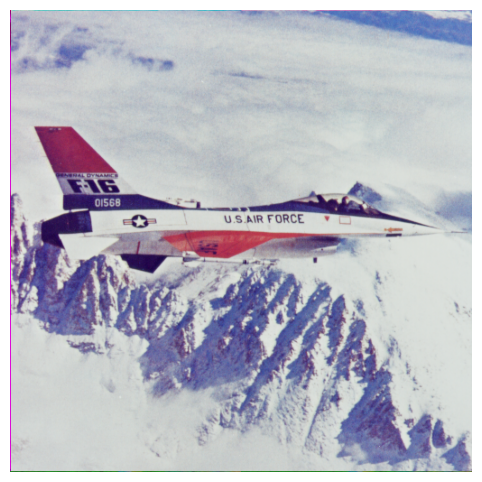

In [32]:
# read the original image
nxd = 512  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(10,6))
axis1.imshow(img)
axis1.set_axis_off()

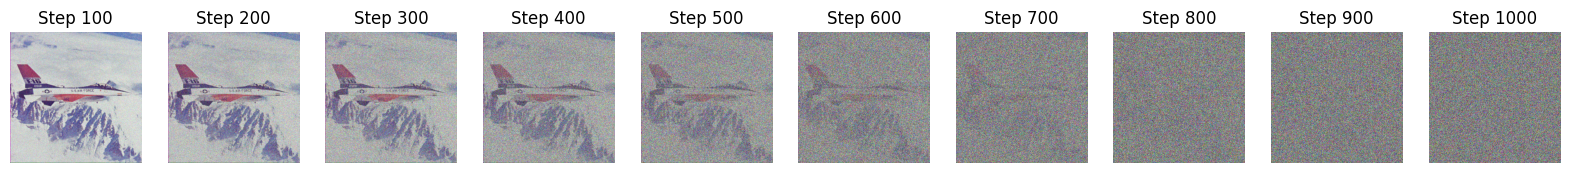

In [4]:
# define forward diffusion function for the DDPM stages
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    # Starting from step 100, I set it as Stage 1. Step 110 -> Stage 2, and so on
    output = np.array(x_t)[100::10]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

def plot_images(x_t, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 12))
    for ax, idx in zip(axes, indices):
        ax.imshow(x_t[idx])
        ax.set_title(f'Step {idx*10+100}')
        ax.axis('off')
    plt.show()

# parameters for forward diffusion
x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

# plot some stages to check the forward diffusion results
plot_images(x_t, indices=[i for i in range(0, 100, 10)])

In [5]:
# setup cnn class
class CNN(nn.Module):
    def __init__(self, n_layer, n_channel, kernel_size):
        super(CNN, self).__init__()
        pd = int(kernel_size/2)
        layers = [nn.Conv2d(3, n_channel, kernel_size, padding=pd), nn.PReLU(),]
        for _ in range(n_layer):
            layers.append(nn.Conv2d(n_channel, n_channel, kernel_size, padding=pd))
            layers.append(nn.BatchNorm2d(n_channel)) # normalize
            layers.append(nn.PReLU())
        layers.append(nn.Conv2d(n_channel, 3, kernel_size, padding=pd))
        
        self.deep_net = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.permute(2, 0, 1)
        return torch.squeeze(self.deep_net(x.unsqueeze(0)))
    
cnn = CNN(32, 64, 3).to(device)

Text(0.5, 1.0, 'input image 512 x 512')

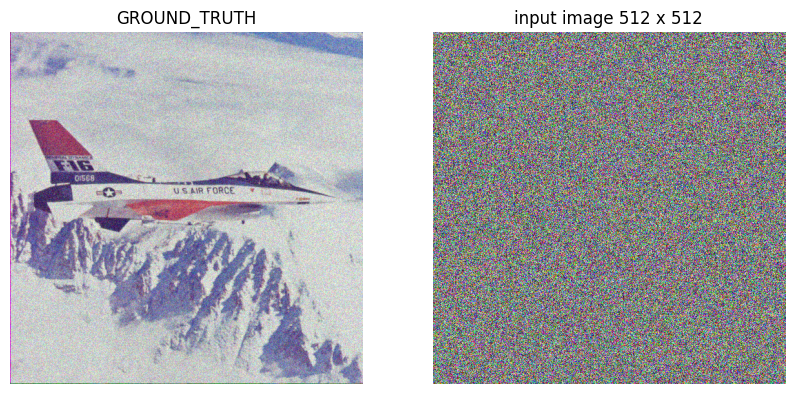

In [31]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

fig2, axis2 = plt.subplots(1, 2, figsize=(10,6))
# I set step 100 image as my ground truth
axis2[0].imshow(x_t[1])
axis2[0].set_title('GROUND_TRUTH')
axis2[0].set_axis_off()
axis2[1].set_axis_off()
axis2[1].imshow(torch_to_numpy(input_image))
axis2[1].set_title('input image %d x %d' %(nxd, nxd))

In [33]:
# initialize training valiables
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_loss = []
psnr_list = []
psnr_list_at_each_stage = []
output_images = []
output_psnr = [] # records max psnr for each stage

print("Total stages:", len(x_t))

Total stages: 91


In [36]:
mse_fn = nn.MSELoss().to(device)

# training process starting from heavily corrupted images
for ind in range(len(x_t)-1, 1, -1):
    psnr_list = []
    cnt = 0
    for ep in tqdm(range(30)):
        optimiser.zero_grad()
        output_image = cnn(input_image)
        output_image = output_image.squeeze(0).permute(1, 2, 0)
        loss = mse_fn(numpy_to_torch(x_t[ind]).to(device), output_image)
    
        train_loss.append(loss.item())
        loss.backward() # find gradients
        optimiser.step() # does the update

        psnr = compare_psnr(torch_to_numpy(output_image), x_t[1], data_range=x_t[1].max())
        
        # early stop the stage when psnr value doesn't increase for 3 consecutive times
        if(ep > 1 and psnr.item() < psnr_list[-1]):
            cnt += 1
        psnr_list.append(psnr.item())
        if(cnt > 3):
            break
    
    print(ind)
    print(loss.item())
    output_images.append(output_image)
    psnr_list_at_each_stage.append(psnr_list)
    output_psnr.append(max(psnr_list))

 30%|███       | 9/30 [00:05<00:13,  1.56it/s]


90
0.08378171920776367


 40%|████      | 12/30 [00:07<00:11,  1.58it/s]


89
0.08230514824390411


 37%|███▋      | 11/30 [00:07<00:12,  1.56it/s]


88
0.08201775699853897


 27%|██▋       | 8/30 [00:05<00:14,  1.53it/s]


87
0.08216138184070587


 33%|███▎      | 10/30 [00:06<00:12,  1.59it/s]


86
0.08183819055557251


 30%|███       | 9/30 [00:05<00:13,  1.58it/s]


85
0.08155477046966553


 30%|███       | 9/30 [00:05<00:13,  1.60it/s]


84
0.08145636320114136


 27%|██▋       | 8/30 [00:05<00:13,  1.59it/s]


83
0.08140944689512253


 20%|██        | 6/30 [00:03<00:15,  1.54it/s]


82
0.08133962005376816


 27%|██▋       | 8/30 [00:05<00:13,  1.60it/s]


81
0.08092247694730759


 27%|██▋       | 8/30 [00:05<00:13,  1.60it/s]


80
0.08077973872423172


 23%|██▎       | 7/30 [00:04<00:14,  1.57it/s]


79
0.08047036826610565


 27%|██▋       | 8/30 [00:05<00:13,  1.59it/s]


78
0.08005010336637497


 23%|██▎       | 7/30 [00:04<00:14,  1.57it/s]


77
0.07980894297361374


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


76
0.07931971549987793


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


75
0.07912003993988037


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


74
0.07913953065872192


 27%|██▋       | 8/30 [00:05<00:14,  1.56it/s]


73
0.07826566696166992


 40%|████      | 12/30 [00:07<00:11,  1.62it/s]


72
0.0771699845790863


 23%|██▎       | 7/30 [00:04<00:14,  1.54it/s]


71
0.07732424139976501


 20%|██        | 6/30 [00:03<00:15,  1.51it/s]


70
0.07699369639158249


 40%|████      | 12/30 [00:07<00:11,  1.63it/s]


69
0.07514794915914536


 17%|█▋        | 5/30 [00:03<00:16,  1.47it/s]


68
0.07616542279720306


 27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]


67
0.0747542455792427


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


66
0.07431448996067047


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


65
0.07358171790838242


 23%|██▎       | 7/30 [00:04<00:14,  1.56it/s]


64
0.07312799245119095


 23%|██▎       | 7/30 [00:04<00:14,  1.56it/s]


63
0.07270203530788422


 47%|████▋     | 14/30 [00:08<00:09,  1.66it/s]


62
0.06987953186035156


 30%|███       | 9/30 [00:05<00:13,  1.60it/s]


61
0.06941841542720795


 30%|███       | 9/30 [00:05<00:13,  1.60it/s]


60
0.06850333511829376


 27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]


59
0.06822212785482407


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


58
0.06825510412454605


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


57
0.06760503351688385


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


56
0.06521376222372055


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


55
0.06414951384067535


 27%|██▋       | 8/30 [00:05<00:14,  1.57it/s]


54
0.06376868486404419


 20%|██        | 6/30 [00:03<00:15,  1.51it/s]


53
0.06358149647712708


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


52
0.06166062876582146


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


51
0.060179926455020905


 27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]


50
0.05976846069097519


 27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]


49
0.058838099241256714


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


48
0.05876757949590683


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


47
0.05653585493564606


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


46
0.056607842445373535


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


45
0.053941525518894196


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


44
0.05443906784057617


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


43
0.05209168791770935


 33%|███▎      | 10/30 [00:06<00:12,  1.62it/s]


42
0.05041329562664032


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


41
0.049382638186216354


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


40
0.048700448125600815


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


39
0.04759163782000542


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


38
0.046304814517498016


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


37
0.044939152896404266


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


36
0.04341907799243927


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


35
0.04317834973335266


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


34
0.04216451197862625


 30%|███       | 9/30 [00:05<00:13,  1.60it/s]


33
0.04008566588163376


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


32
0.038932692259550095


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


31
0.03790908679366112


 33%|███▎      | 10/30 [00:06<00:12,  1.62it/s]


30
0.036806922405958176


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


29
0.03605841100215912


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


28
0.03494208678603172


 30%|███       | 9/30 [00:05<00:13,  1.60it/s]


27
0.03296240046620369


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


26
0.03227014094591141


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


25
0.03129807114601135


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


24
0.029940402135252953


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


23
0.029237141832709312


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


22
0.02739606611430645


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


21
0.026452042162418365


 27%|██▋       | 8/30 [00:05<00:13,  1.58it/s]


20
0.025770477950572968


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


19
0.024804651737213135


 20%|██        | 6/30 [00:03<00:15,  1.52it/s]


18
0.02359589748084545


 27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]


17
0.02206963300704956


 40%|████      | 12/30 [00:07<00:11,  1.64it/s]


16
0.020653296262025833


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


15
0.020545046776533127


 30%|███       | 9/30 [00:05<00:13,  1.59it/s]


14
0.01890338584780693


 37%|███▋      | 11/30 [00:06<00:11,  1.62it/s]


13
0.01759353093802929


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


12
0.01703491061925888


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


11
0.016181565821170807


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


10
0.015012478455901146


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


9
0.014139004051685333


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


8
0.013215601444244385


 30%|███       | 9/30 [00:05<00:13,  1.59it/s]


7
0.011865958571434021


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


6
0.011223288252949715


 33%|███▎      | 10/30 [00:06<00:12,  1.61it/s]


5
0.009899196214973927


 23%|██▎       | 7/30 [00:04<00:14,  1.55it/s]


4
0.009349693544209003


 27%|██▋       | 8/30 [00:05<00:13,  1.57it/s]


3
0.008307099342346191


 40%|████      | 12/30 [00:07<00:11,  1.63it/s]

2
0.007174327038228512


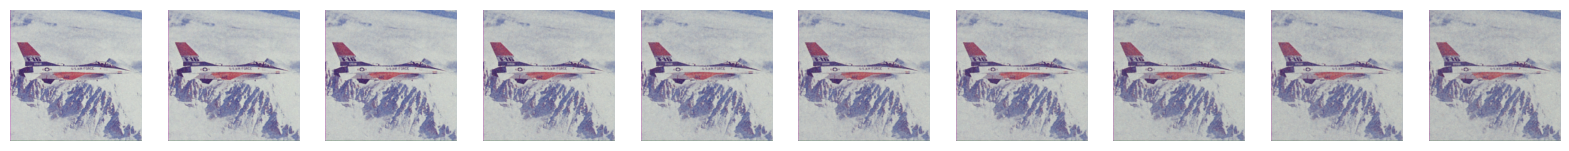

In [37]:
# plot the result images from last 10 stages
fig1, axis1 = plt.subplots(1, 10, figsize=(20,12))
for i in range(1, 11):
    axis1[i-1].set_axis_off()
    axis1[i-1].imshow(torch_to_numpy(output_images[i*-1]))

Text(0.5, 1.0, 'Output Image')

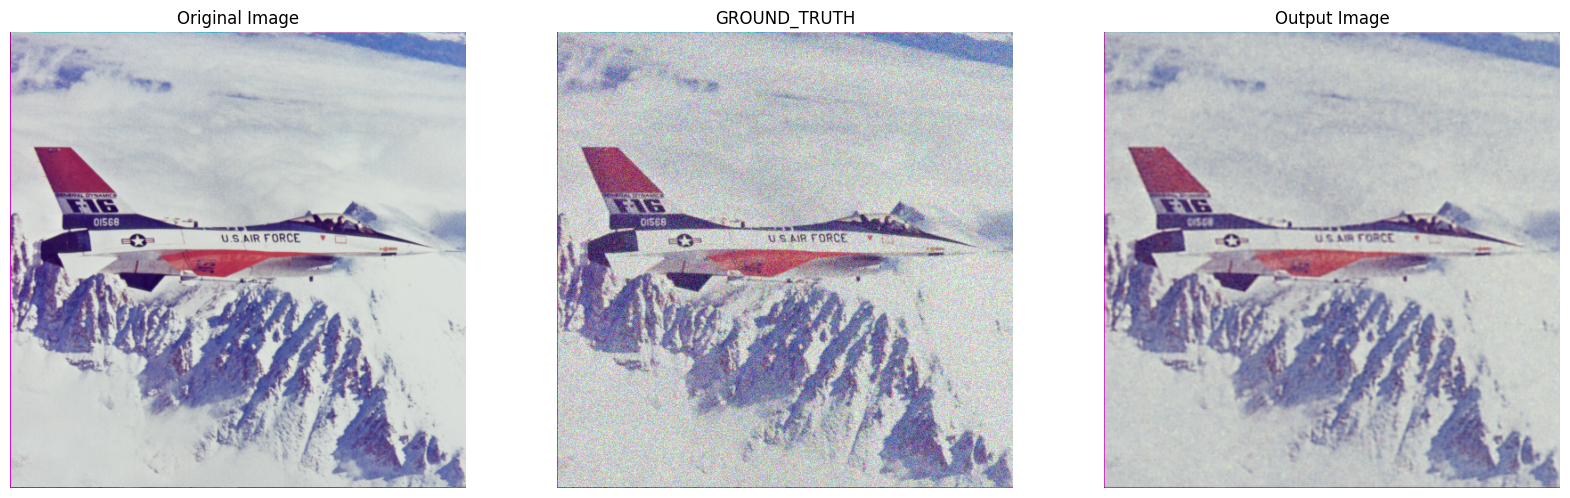

In [38]:
fig1, axis1 = plt.subplots(1, 3, figsize=(20,12))
axis1[0].imshow(img)
axis1[0].set_axis_off()
axis1[0].set_title('Original Image')
axis1[1].imshow(x_t[1])
axis1[1].set_axis_off()
axis1[1].set_title('GROUND_TRUTH')
axis1[2].imshow(torch_to_numpy(output_images[-1]))
axis1[2].set_axis_off()
axis1[2].set_title('Output Image')

Text(0, 0.5, 'MSE')

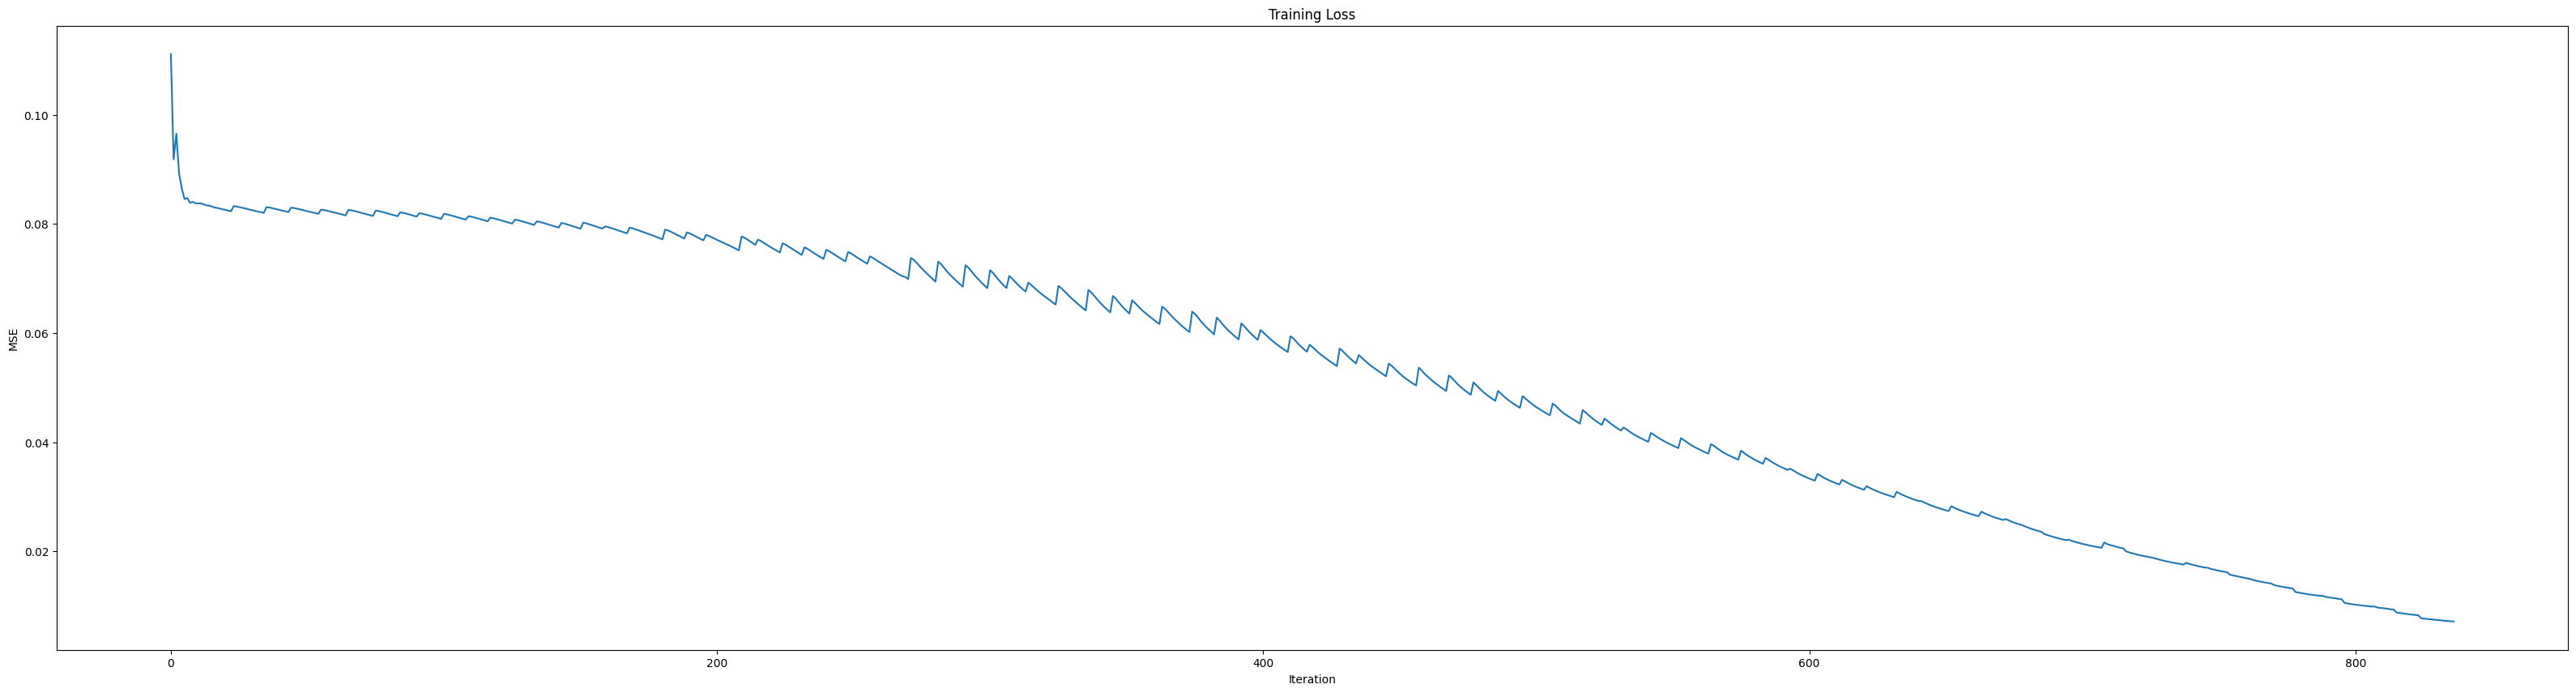

In [44]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(train_loss)
axis1.set_title('Training Loss')
plt.xlabel("Iteration")
plt.ylabel("MSE")

Text(0, 0.5, 'PSNR')

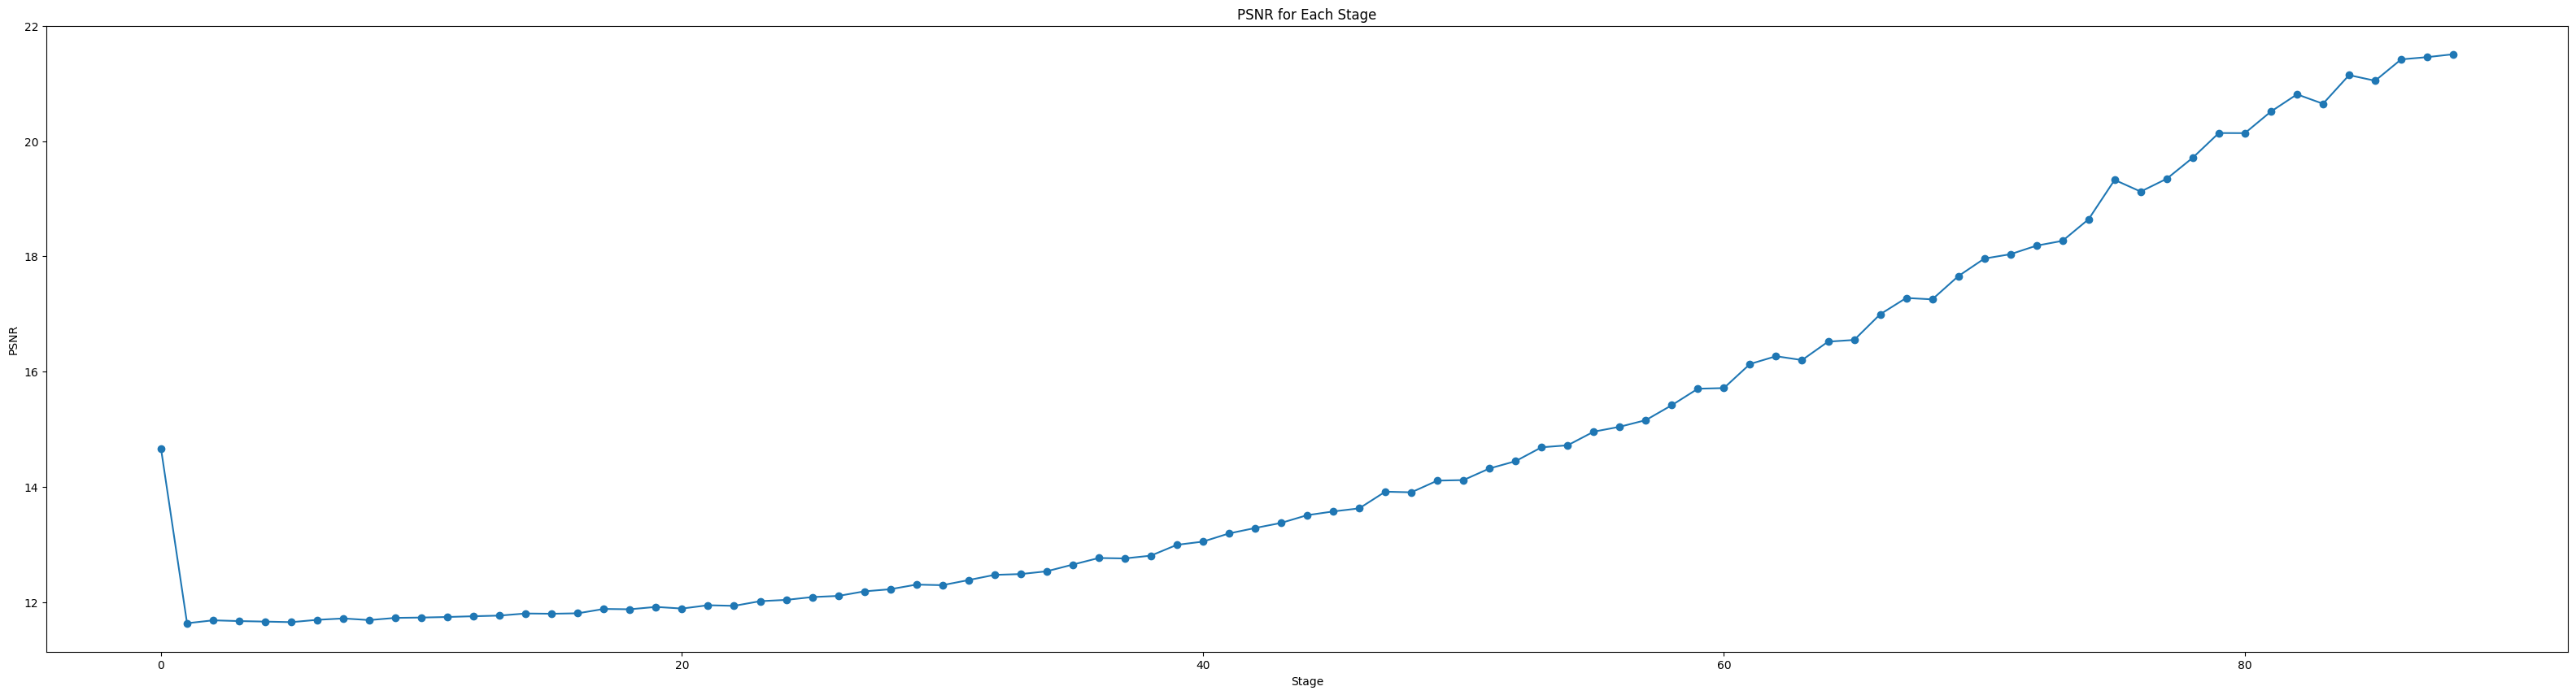

In [45]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(output_psnr, marker = 'o')
axis1.set_title('PSNR for Each Stage')
plt.xlabel("Stage")
plt.ylabel("PSNR")

In [41]:
# Calculate PSNR for output image and original image
original_img = (img - img.min()) / (img.max() - img.min())
compare_psnr(torch_to_numpy(output_images[-1]), original_img, data_range=original_img.max())

20.11034920305614